In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

In [2]:
class Affine: 
    """somewhat overkill class for affine transformation"""
    def __init__(self):
        # Initialize A and b as None, to be set after fitting
        self.A = None
        self.b = None

    def fit(self, xy_targets, xy_eyes):
        """
        Fits the affine transformation matrix and translation vector.
        
        Parameters:
        xy_targets (numpy array): [N, 2] matrix representing the target coordinates.
        xy_eyes (numpy array): [N, 2] matrix representing the eye-tracking coordinates.
        
        Sets:
        self.A : 2x2 affine transformation matrix.
        self.b : 2-dimensional translation vector.
        """
        if xy_eyes.ndim == 3:
            N, _, n_repeat = xy_eyes.shape
            xy_eyes = xy_eyes.transpose((0,2,1)).reshape(N * n_repeat, 2)
            xy_targets = np.repeat(xy_targets, n_repeat, axis=0)
            
        mask = ~np.isnan(xy_eyes).any(axis=1)
        xy_eyes = xy_eyes[mask]
        xy_targets = xy_targets[mask]
                
        # Add a column of ones for the translation term
        xy_eyes_augmented = np.hstack([xy_eyes, np.ones((xy_eyes.shape[0], 1))])
        
        # Solve for the affine transformation using least squares
        params, _, _, _ = np.linalg.lstsq(xy_eyes_augmented, xy_targets, rcond=None)
        
        self.A = params[:2, :].T  # 2x2 affine matrix
        self.b = params[2, :]     # 2x1 translation vector

        
    def transform(self, xy_eyes):
        """
        Applies the fitted affine transformation to the eye-tracking coordinates.
        
        Parameters:
        xy_eyes (numpy array): [N, 2] matrix representing the eye-tracking coordinates.
        
        Returns:
        xy_transformed (numpy array): [N, 2] matrix representing the transformed coordinates.
        """
    
        if self.A is None or self.b is None:
            raise ValueError("The affine transformation has not been fitted yet.")
        
        # Handle both 2D and 3D cases
        is_3d = (xy_eyes.ndim == 3)
        if is_3d:
            N, _, n_repeat = xy_eyes.shape
            xy_eyes = xy_eyes.transpose((0,2,1)).reshape(N * n_repeat, 2)

        # Apply the transformation: XY_transformed = XY_eye @ A.T + T
        xy_transformed = xy_eyes @ self.A.T + self.b

        # Reshape back to original shape if it was 3D
        if is_3d:
            return xy_transformed.reshape(N, n_repeat, 2).transpose((0,2,1))
        else:
            return xy_transformed

In [8]:
data_exp = loadmat( 'jiwon_calib.mat' ) 
n_events = data_exp['myscreen'][0,0][80][0,0][0][0,0]
myscreen = {
    'time'     : data_exp['myscreen'][0,0][80][0,0][5][0,:n_events],
    'tracenum' : data_exp['myscreen'][0,0][80][0,0][1][0,:n_events],
}
myscreen['backtick_time'] = myscreen['time'][ np.where(myscreen['tracenum']==2)[0][0] ] # in MGL timestamps
myscreen['calib_xy_targets'] = data_exp['myscreen'][0,0][99][0][0][0,0] # in MGL visual angle
myscreen['calib_xy_eyes']    = data_exp['myscreen'][0,0][99][0][0][0,1] # in MGL visual angle
median_eyes = np.median(myscreen['calib_xy_eyes'], axis=2)

In [21]:
affine = Affine()
affine.fit(myscreen['calib_xy_targets'], 
           median_eyes)
calib_pos = { 'targ': myscreen['calib_xy_targets'], 
              'trans': affine.transform(myscreen['calib_xy_eyes']) }

In [12]:
np.shape(median_eyes)

(170, 2)

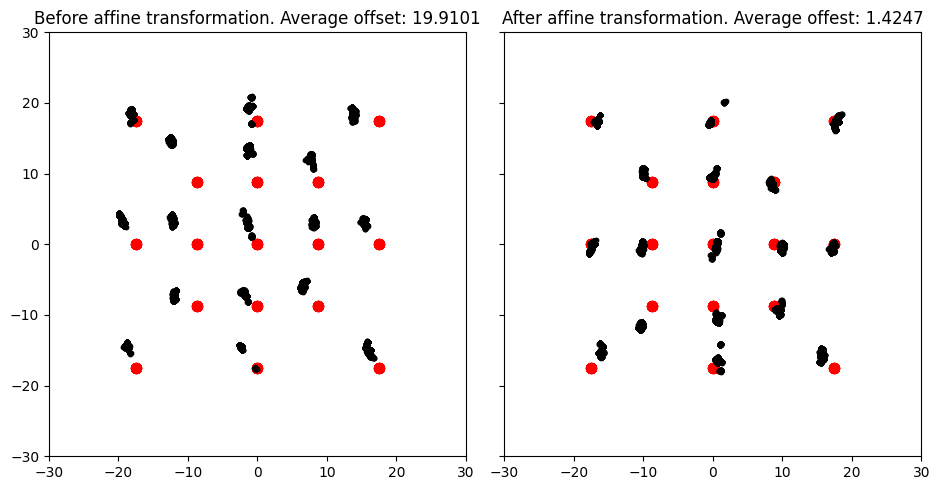

In [26]:
f,ax = plt.subplots(1,2,figsize=[9.5,5], sharex=True, sharey=True)
for i in range(2):
    ax[i].scatter(calib_pos['targ'][:,0], calib_pos['targ'][:,1], color='red', s=50)
    ax[i].set_xlim([-30,30])
    ax[i].set_ylim([-30,30])


for trans_x, transy in zip(myscreen['calib_xy_eyes'][:,0,:], myscreen['calib_xy_eyes'][:,1,:]):
    ax[0].scatter(trans_x, transy, color='k', s=10)

for trans_x, transy in zip(calib_pos['trans'][:,0,:], calib_pos['trans'][:,1,:]):
    ax[1].scatter(trans_x, transy, color='k', s=10)

# compute overall offset 
eye_offset = np.linalg.norm(calib_pos['targ']-np.median(myscreen['calib_xy_eyes'], axis=2), axis=1)
affine_offset = np.linalg.norm(calib_pos['targ']-np.median(calib_pos['trans'], axis=2), axis=1)

ax[0].set_title(f'Before affine transformation. Average offset: {np.average(eye_offset):.4f}')
ax[1].set_title(f'After affine transformation. Average offest: {np.average(affine_offset):.4f}')
plt.tight_layout()
plt.show()